In [1]:
from libraries.energyPointGame import energy_point_game
from libraries.ImageUtil import find_original_image_name
from libraries.bcosconv2d import NormedConv2d

import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader


from dataset.pneumonia_dataset import PneumoniaDataset
from dataset.augmentations import no_augmentations

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
explanation_folder = r"C:\Users\Admin\Documents\MasterThesis\prediction_images\onePrediction"
model_path = r"C:\Users\Admin\Documents\MasterThesis\BestPerformingResNet50BCosResult\pneumonia_detection_model_bcos_trans_bestf1_1_24.pth"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Modify model and load model
model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)    
model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.to(device)


data = pd.read_csv(csv_path)
with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

# Loop over whole validation set of first fold 
first_split = splits[0] # fold selection
val_idx = first_split[1]  # Only use the validation indices from the first fold
val_data = data.iloc[val_idx]
transform = no_augmentations() # no transformation
val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

proportions = []
proportions_correct = []
proportions_incorrect = []
count_correct = 0
count_incorrect = 0
model.eval()
with torch.no_grad():
    for images, labels, patient_ids in val_loader:
        images, labels = images.to(device), labels.to(device)
        six_channel_images = []
        for img_tensor in images:
            numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
            pil_image = Image.fromarray(numpy_image)
            transformed_image = model.transform(pil_image)
            six_channel_images.append(transformed_image)
        six_channel_images = torch.stack(six_channel_images).to(device)
        
        for image, label, patient_id in zip(six_channel_images, labels, patient_ids):
            filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
            if not filtered_rows.empty: 
                image = image[None]
                expl = model.explain(image)
                prediction = expl['prediction']
                contribution_map = expl['contribution_map'].squeeze(0).cpu()
                proportion = 0.0
                for _, row in filtered_rows.iterrows():
                    x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                    coordinates_list = [x, y, x + width, y + height]
                    coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                    proportion = proportion + energy_point_game(coordinates_tensor, contribution_map)
                if prediction == 1:
                    proportions_correct.append(proportion)
                    count_correct = count_correct + 1
                else:
                    proportions_incorrect.append(proportion)
                    count_incorrect = count_incorrect + 1
                proportions.append(proportion)
                

if proportions:
    avg_proportion = sum(proportions) / len(proportions)
    avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
    avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
    print(f"Average Energy-Based Pointing Game Proportion: {avg_proportion}")
    print(f"Average Energy-Based Pointing Game Proportion of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}")
    print(f"Average Energy-Based Pointing Game Proportion of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}")

else:
    print("No valid proportions were found.")





Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Average Energy-Based Pointing Game Proportion: 0.16265983879566193
Average Energy-Based Pointing Game Proportion of Incorrectly Classified Images: 0.09550964087247849, Count: 562
Average Energy-Based Pointing Game Proportion of Correctly Classified Images: 0.181115984916687, Count: 563


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images\ff5efd4a-0777-41b9-82c7-b73b4073c509
BBox: 2.462703227996826, Whole: 19.373046875
Proportion 0.12712007761001587
BBox: 1.7454428672790527, Whole: 19.373046875
Proportion 0.09009645879268646


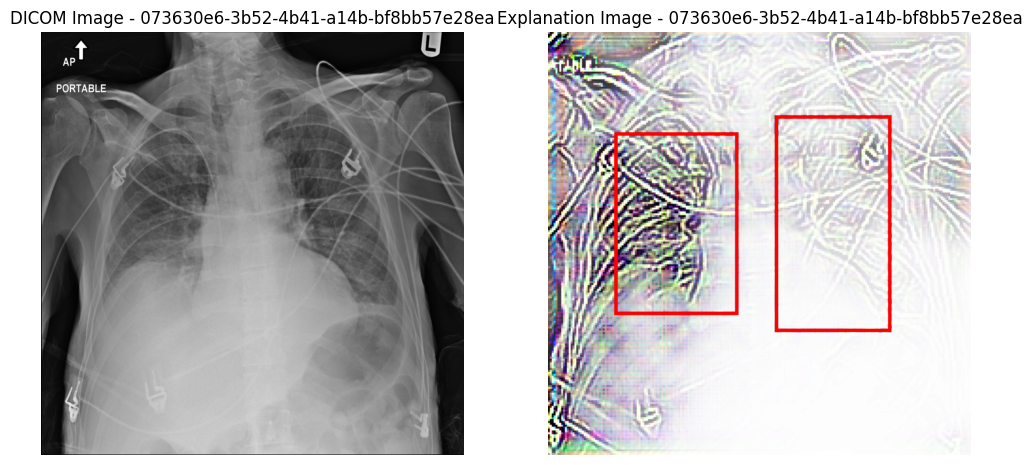

In [13]:
import os
import random
import sys
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from PIL import Image
import pydicom
from sklearn.model_selection import KFold
from bcosconv2d import NormedConv2d
from torchvision.transforms import functional as TF

from torchvision.transforms import ToPILImage
from libraries.ImageUtil import find_original_image_name
from PIL import Image, ImageDraw

from libraries.energyPointGame import energy_point_game



np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

model_path = r"C:\Users\Admin\Documents\MasterThesis\BestPerformingResNet50BCosResult\pneumonia_detection_model_bcos_trans_bestf1_1_24.pth"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224



torch.hub.list('B-cos/B-cos-v2')

model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)    
model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

# Load trained weights (optional)
model = model.to(device)

patient_id = "073630e6-3b52-4b41-a14b-bf8bb57e28ea"
image_path = os.path.join(image_folder,"073630e6-3b52-4b41-a14b-bf8bb57e28ea.dcm")
dicom = pydicom.dcmread(image_path)
image = Image.fromarray(dicom.pixel_array).convert("RGB")

img_new = model.transform(image)
img_new = img_new[None]
img_new = img_new.to(device)


# A: 19.297964096069336, B: -0.012265102937817574 sum positive and negative values

model.eval()
expl = model.explain(img_new)
explanation_image_array = expl['explanation']
explanation_image_array = (explanation_image_array * 255).astype(np.uint8)
explanation_image = Image.fromarray(explanation_image_array)


contribution_map = expl['contribution_map'].squeeze(0)
#positive_map = torch.where(contribution_map>=0, 0, contribution_map)
#contribution_map_no_neg = torch.where(contribution_map<0, 0, contribution_map)

# Plot side by side
plt.figure(figsize=(12, 6))

# DICOM image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title(f"DICOM Image - {patient_id}")
plt.axis("off")

# 
plt.subplot(1, 2, 2)
plt.imshow(explanation_image)
plt.title(f"Explanation Image - {patient_id}")
plt.axis("off")

my_image = r"C:\Users\Admin\Downloads\prediction_comparison\ff5efd4a-0777-41b9-82c7-b73b4073c509_normal_explanation.png"
original_image_name = find_original_image_name(image_folder, my_image)

#print(contribution_map)
df = pd.read_csv(csv_path)

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

filtered_rows = df[(df['patientId'] == '073630e6-3b52-4b41-a14b-bf8bb57e28ea') & (df['Target'] == 1)]

for _, row in filtered_rows.iterrows():
    x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y) # not ints
    
    explanation_draw = ImageDraw.Draw(explanation_image)
    explanation_draw.rectangle([(x, y), (x + width, y + height)], outline="red", width=2)

    coordinates_list = [x, y, x + width, y + height]
    coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
    contribution_map = contribution_map.cpu()
    proportion = energy_point_game(coordinates_tensor, contribution_map)
    
    print(f"Proportion {proportion}")

plt.imshow(explanation_image)
plt.show()


## bbox and saliency map
#energy_point_game("","")


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


RuntimeError: The size of tensor a (64) must match the size of tensor b (6) at non-singleton dimension 0